In [24]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from gala.units import UnitSystem

In [25]:
usys = UnitSystem(u.kpc, 1e12*u.Msun, u.Gyr, u.radian)

In [2]:
from astropy.constants import G
from gala.units import UnitSystem
from scipy.optimize import root, minimize

# from yellowcard.keplerianPlane import LGKepler
# from yellowcard.coordinates import fiducial_m31_c, LocalGroupHalocentric

In [3]:
import numpy as np
import astropy.units as u
from astropy.constants import G


class LGKepler:
    '''
    This class defines the keplerian plane of the local group.
    The
    -------
    '''

    def __init__(self, semiMajorAxis, eccentricity, eccentricAnomaly, totalMass):
         # initializing the cosmology
        self.a    = semiMajorAxis    # in kpc
        self.e    = eccentricity     # dimensionless
        self.eta  = eccentricAnomaly # dimensionless
        self.Mtot = totalMass       # in Msun
        self.G    = G # in kpc^3/s^2/Msun

    @property
    def separation(self):
        return self.a * ( 1 - self.e * np.cos(self.eta) )

    @property
    def time(self):
        A = self.a**3 / (self.G * self.Mtot)
        B = self.eta - ( self.e * np.sin(self.eta) )
        return A**(-1/2) * B

    @property
    def vrad_kepler(self):
        A = self.a / (self.G * self.Mtot)
        B = self.e * np.sin(self.eta)
        C = 1 - (self.e*np.cos(self.eta))
        return A**(-1/2) * B/C

    @property
    def vtan_kepler(self):
        A = self.a / (self.G * self.Mtot)
        B = ( 1 - self.e**2 )**(1/2)
        C = 1 - ( self.e * np.cos(self.eta) )
        return A**(-1/2) * B/C

    @property
    def trueAnomaly(self):
        A = ( 1+self.e )/(1-self.e )
        B = np.tan( self.eta / 2 )
        return 2 * np.arctan( np.sqrt(A) * B )

    @property
    def xy(self):
        return self.separation * np.cos( self.trueAnomaly ), self.separation * np.sin( self.trueAnomaly )

    @property
    def vxy(self):
        return self.vrad_kepler * np.cos( self.trueAnomaly ) - self.vtan_kepler * np.sin( self.trueAnomaly ),  self.vrad_kepler * np.sin( self.trueAnomaly ) + self.vtan_kepler * np.cos( self.trueAnomaly )

In [4]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u

# Sky coordinates, Distance and RV from Mcconachie 2012
# Proper motions from Table 2: (Blue) https://arxiv.org/pdf/2012.09204.pdf
fiducial_m31_c = coord.SkyCoord(
    ra=10.68470833 * u.deg,
    dec=41.26875 * u.deg,
    distance=731 * u.kpc,
    pm_ra_cosdec=48.98 * u.microarcsecond/u.yr,
    pm_dec=-36.85 * u.microarcsecond/u.yr,
    radial_velocity=-300 * u.km/u.s
)

galcen_frame = coord.Galactocentric()
m31_galcen = fiducial_m31_c.transform_to(galcen_frame)
m31_galcen_pos = m31_galcen.data.without_differentials()
m31_galcen_vel = m31_galcen.velocity
L_mw_m31 = m31_galcen_pos.cross(m31_galcen_vel)
fiducial_lg_pole = L_mw_m31 / L_mw_m31.norm()


class LocalGroupHalocentric(coord.BaseCoordinateFrame):
    """
    Position at the Milky Way Halo barycenter, x-axis toward M31,
    z-axis toward the Local Group angular momentum vector.
    """

    default_representation = coord.CartesianRepresentation
    default_differential = coord.CartesianDifferential

    # Frame attributes
    m31_coord = coord.CoordinateAttribute(
        frame=coord.ICRS,
        default=fiducial_m31_c
    )
    
    # Pole of Local Group coordinate system at MW Halocenter
    lg_pole = coord.CartesianRepresentationAttribute(
        default=fiducial_lg_pole,
        unit=u.one
    )


def get_galcen_to_lg_transform(lg_frame, galcen_frame, inverse=False):
    """
    This function returns the matrix and (position and velocity) offset
    vectors to transform from a Milky Way Galactocentric reference frame to
    a Local Group Barycenter reference frame.

    Astropy coordinate frames are mostly defined as affine transformations from
    one frame to another. Transformations between inertial frames are given by
    affine transformations, which are defined as A x + b, where A is a matrix
    (typically a rotation matrix: orthogonal matrix with determinant 1),
    x and b are vectors.

    Parameters
    ----------
    lg_frame : `yellowcard.coordinates.LocalGroupHalocentric` instance
    galcen_frame : `astropy.coordinates.Galactocentric` instance
    matrix_only : bool (optional)
        If True, return only the rotation matrix.
    inverse : bool (optional)
        If True, returns the matrix (and offset) for the inverse transform, to
        go from `LocalGroupHalocentric` to `Galactocentric`.

    """
    # shorthand
    lg = lg_frame

    # Get the line connecting M31 to MW center, and angular momentum
    # vector to specify the orientation / rotation around the line
    m31_galcen = lg.m31_coord.transform_to(galcen_frame)
    m31_galcen_pos = m31_galcen.data.without_differentials()
    lg_pole = lg.lg_pole

    # Rotation matrix to align x(Galcen) with the vector to M31 and
    # z(Galcen) with the LG angular momentum vector
    new_x = m31_galcen_pos / m31_galcen_pos.norm()
    new_z = lg_pole
    new_y = - new_x.cross(new_z)
    R = coord.concatenate_representations((new_x, new_y, new_z)).xyz.T

    if inverse:
        return R.T
    else:
        return R


@coord.frame_transform_graph.transform(
    coord.transformations.DynamicMatrixTransform,
    coord.Galactocentric,
    LocalGroupHalocentric
)
def galactocentric_to_lghalocentric(galactocentric_coord, lg_frame):
    return get_galcen_to_lg_transform(lg_frame, galactocentric_coord,
                                      inverse=False)


@coord.frame_transform_graph.transform(
    coord.transformations.DynamicMatrixTransform,
    LocalGroupHalocentric,
    coord.Galactocentric
)
def lghalocentric_to_galactocentric(lg_coord, galactocentric_frame):
    return get_galcen_to_lg_transform(lg_coord, galactocentric_frame,
                                      inverse=True)


In [5]:
def ln_normal(data_val, model_val, variance):
    ''' computes ln normal given a data value and model predicted value '''
    A = 2*np.pi*variance
    B = -1/2 * ( (data_val - model_val)**2 / variance )
    return -1/2 * np.log(A) - B


class TimingArgumentModel:

    def __init__(self, 
                 distance, pm, radial_velocity,
                 distance_err, pm_err, rv_err, 
                 pm_correlation=0., usys=None, galcen_frame=None):
    
        if usys is None:
            usys = UnitSystem(u.kpc, u.Gyr, 1e12*u.Msun, u.radian)
        self.usys = usys

        self.y = np.array([
            distance.decompose(self.usys).value,
            pm[0].decompose(self.usys).value,
            pm[1].decompose(self.usys).value,
            radial_velocity.decompose(self.usys).value
        ])
        
        self.C = np.zeros((len(self.y), len(self.y)))
        self.C[0, 0] = distance_err.decompose(self.usys).value ** 2
        self.C[1, 1] = pm_err[0].decompose(self.usys).value ** 2
        self.C[2, 2] = pm_err[1].decompose(self.usys).value ** 2
        self.C[3, 3] = rv_err.decompose(self.usys).value ** 2
        
        self._param_info = {
            'a': 1,
            'e_coseta': 1,
            'e_sineta': 1,
            'M': 1,
            'lg_pole_x': 1,
            'lg_pole_y': 1,
            'lg_pole_z': 1,
        }
        
        self.frozen = {}
        
        if galcen_frame is None:
            galcen_frame = coord.Galactocentric()
        self.galcen_frame = galcen_frame

    def unpack_pars(self, par_list):
        i = 0
        par_dict = {}
        for key, par_len in self._param_info.items():
            if key in self.frozen:
                par_dict[key] = self.frozen[key]
            else:
                par_dict[key] = np.squeeze(par_list[i:i+par_len])
                i += par_len

        return par_dict

    def pack_pars(self, par_dict):
        parvec = []
        for i, k in enumerate(self._param_info):
            if k not in self.frozen:
                parvec.append(np.atleast_1d(par_dict[k]))
        return np.concatenate(parvec)

    def ln_likelihood(self, par_dict):        
        eta = np.arctan2(par_dict['e_sineta'], par_dict['e_coseta'])
        e = np.sqrt(par_dict['e_sineta']**2 + par_dict['e_coseta']**2)
        
        kepler = LGKepler(
            semiMajorAxis=par_dict['a'] * self.usys['length'], 
            eccentricity=e, 
            eccentricAnomaly=eta, 
            totalMass=par_dict['M'] * self.usys['mass']
        )

        lghc_pos = coord.CartesianRepresentation(
            x=kepler.separation, 
            y=0*u.kpc, 
            z=0*u.kpc
        )
        lghc_vel = coord.CartesianDifferential(
            d_x=kepler.vrad_kepler, 
            d_y=kepler.vtan_kepler, 
            d_z=0*u.km/u.s
        )
        
        lg_pole = coord.CartesianRepresentation(
            x=par_dict['lg_pole_x'] * u.one,
            y=par_dict['lg_pole_y'] * u.one,
            z=par_dict['lg_pole_z'] * u.one
        )
        lg_pole = lg_pole / lg_pole.norm()
        
        # Law of Cosines
        gamma = self.galcen_frame.galcen_coord.separation(fiducial_m31_c)
        s = self.galcen_frame.galcen_distance
        D = kepler.separation
        d_M31_sun = s*np.cos(gamma) + np.sqrt(s**2*np.cos(gamma)**2 - s**2 + D**2)
        
        lg_frame = LocalGroupHalocentric(
            m31_coord=coord.SkyCoord(fiducial_m31_c.ra, fiducial_m31_c.dec, d_M31_sun), 
            lg_pole=lg_pole.to_cartesian()
        )
        lg_coord = lg_frame.realize_frame(lghc_pos.with_differentials(lghc_vel))
        m31_galcen = lg_coord.transform_to(self.galcen_frame)
        model_m31_icrs = m31_galcen.transform_to(coord.ICRS())
        
        model_y = np.array([
            model_m31_icrs.distance.decompose(self.usys).value,
            model_m31_icrs.pm_ra_cosdec.decompose(self.usys).value,
            model_m31_icrs.pm_dec.decompose(self.usys).value,
            model_m31_icrs.radial_velocity.decompose(self.usys).value
        ])
        
        dy = model_y - self.y
        ll = -0.5 * dy.T @ np.linalg.inv(self.C) @ dy
        return ll

    def ln_prior(self, par_dict):
        # TODO: need to discuss
        
        for key in ['lg_pole_x', 'lg_pole_y', 'lg_pole_z']:
            if not -10 < par_dict[key] < 10:
                return -np.inf
        
        for key in ['e_coseta', 'e_sineta']:
            if not -1 < par_dict[key] < 1:
                return -np.inf
        
        return 0.

    def ln_posterior(self, par_dict):
        # TODO: call ln_likelihood and ln_prior and add the values
        return self.ln_likelihood(par_dict) + self.ln_prior(par_dict)

    def __call__(self, par_arr):
        par_dict = self.unpack_pars(par_arr)
        try:
            lnpost = self.ln_posterior(par_dict)
        except:
            return -np.inf
        
        if not np.isfinite(lnpost):
            return -np.inf
        
        return lnpost

In [6]:
model = TimingArgumentModel(
    distance=fiducial_m31_c.distance,
    distance_err=5*u.kpc,
    pm=[fiducial_m31_c.pm_ra_cosdec, fiducial_m31_c.pm_dec],
    pm_err=[10, 8] * u.microarcsecond / u.year,
    radial_velocity=-300*u.km/u.s,
    rv_err=10*u.km/u.s
)

In [7]:
e = 0.5
eta = 300 * u.deg

init_p = {
    'e_coseta': e * np.cos(eta),
    'e_sineta': e * np.sin(eta),
    'M': (3e12 * u.Msun).decompose(model.usys).value
}

m31_galcen = fiducial_m31_c.transform_to(model.galcen_frame)
_d = m31_galcen.spherical.distance.decompose(model.usys).value
init_p['a'] = _d / (1 - e * np.cos(eta))

# _lg_pole_sph = fiducial_lg_pole.represent_as(coord.SphericalRepresentation)
# init_p['lg_pole_lon'] = _lg_pole_sph.lon.to_value(model.usys['angle'])
# init_p['lg_pole_lat'] = _lg_pole_sph.lat.to_value(model.usys['angle'])
init_p['lg_pole_x'] = fiducial_lg_pole.x.value
init_p['lg_pole_y'] = fiducial_lg_pole.y.value
init_p['lg_pole_z'] = fiducial_lg_pole.z.value

In [8]:
x0 = model.pack_pars(init_p)

res = minimize(lambda args: -model.ln_likelihood(model.unpack_pars(args)), 
               method='L-BFGS-B',
               x0=x0, bounds=[(500, 1e4), (-0.99, 0.99), (-0.99, 0.99), (0.5, 5), 
                              (-10, 10), (-10, 10), (-10, 10)])

<ipython-input-3-d363ab62501d>:41: RuntimeWarning: invalid value encountered in double_scalars
  B = ( 1 - self.e**2 )**(1/2)



In [9]:
res

      fun: nan
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.27231458e-02, -3.55940877e-01,  7.85977740e+01, -3.29564609e+00,
       -6.12457815e-01, -1.33356366e+00, -2.07096012e+00])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 16
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 9.79925669e+02,  2.50000000e-01, -4.33012702e-01,  3.00000000e+00,
       -8.37202186e-01, -3.12497297e-01,  4.48818381e-01])

In [10]:
model.unpack_pars(res.x)

{'a': array(979.92566892),
 'e_coseta': array(0.25),
 'e_sineta': array(-0.4330127),
 'M': array(3.),
 'lg_pole_x': array(-0.83720219),
 'lg_pole_y': array(-0.3124973),
 'lg_pole_z': array(0.44881838)}

In [11]:
from emcee import EnsembleSampler

In [12]:
sampler = EnsembleSampler(nwalkers=6 * 8, ndim=len(res.x), log_prob_fn=model)
walker_x0 = np.random.normal(res.x, 1e-3, size=(sampler.nwalkers, len(res.x)))
chain = sampler.run_mcmc(walker_x0, nsteps=128, progress=True)

 20%|██        | 26/128 [00:32<01:54,  1.12s/it]

<ipython-input-3-d363ab62501d>:41: RuntimeWarning: invalid value encountered in double_scalars
  B = ( 1 - self.e**2 )**(1/2)



 38%|███▊      | 48/128 [01:05<01:28,  1.10s/it]

/Users/apricewhelan/anaconda/lib/python3.8/site-packages/astropy/units/quantity.py:507: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



100%|██████████| 128/128 [02:33<00:00,  1.20s/it]


In [19]:
sampler.reset()
chain = sampler.run_mcmc(chain, nsteps=128, progress=True)

  1%|          | 1/128 [00:00<01:48,  1.17it/s]

<ipython-input-3-d363ab62501d>:41: RuntimeWarning: invalid value encountered in double_scalars
  B = ( 1 - self.e**2 )**(1/2)



  2%|▏         | 2/128 [00:01<01:47,  1.17it/s]

/Users/apricewhelan/anaconda/lib/python3.8/site-packages/astropy/units/quantity.py:507: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



100%|██████████| 128/128 [01:58<00:00,  1.08it/s]


In [20]:
import arviz as az

array([[<AxesSubplot:title={'center':'var_0'}>,
        <AxesSubplot:title={'center':'var_0'}>],
       [<AxesSubplot:title={'center':'var_1'}>,
        <AxesSubplot:title={'center':'var_1'}>],
       [<AxesSubplot:title={'center':'var_2'}>,
        <AxesSubplot:title={'center':'var_2'}>],
       [<AxesSubplot:title={'center':'var_3'}>,
        <AxesSubplot:title={'center':'var_3'}>],
       [<AxesSubplot:title={'center':'var_4'}>,
        <AxesSubplot:title={'center':'var_4'}>],
       [<AxesSubplot:title={'center':'var_5'}>,
        <AxesSubplot:title={'center':'var_5'}>],
       [<AxesSubplot:title={'center':'var_6'}>,
        <AxesSubplot:title={'center':'var_6'}>]], dtype=object)

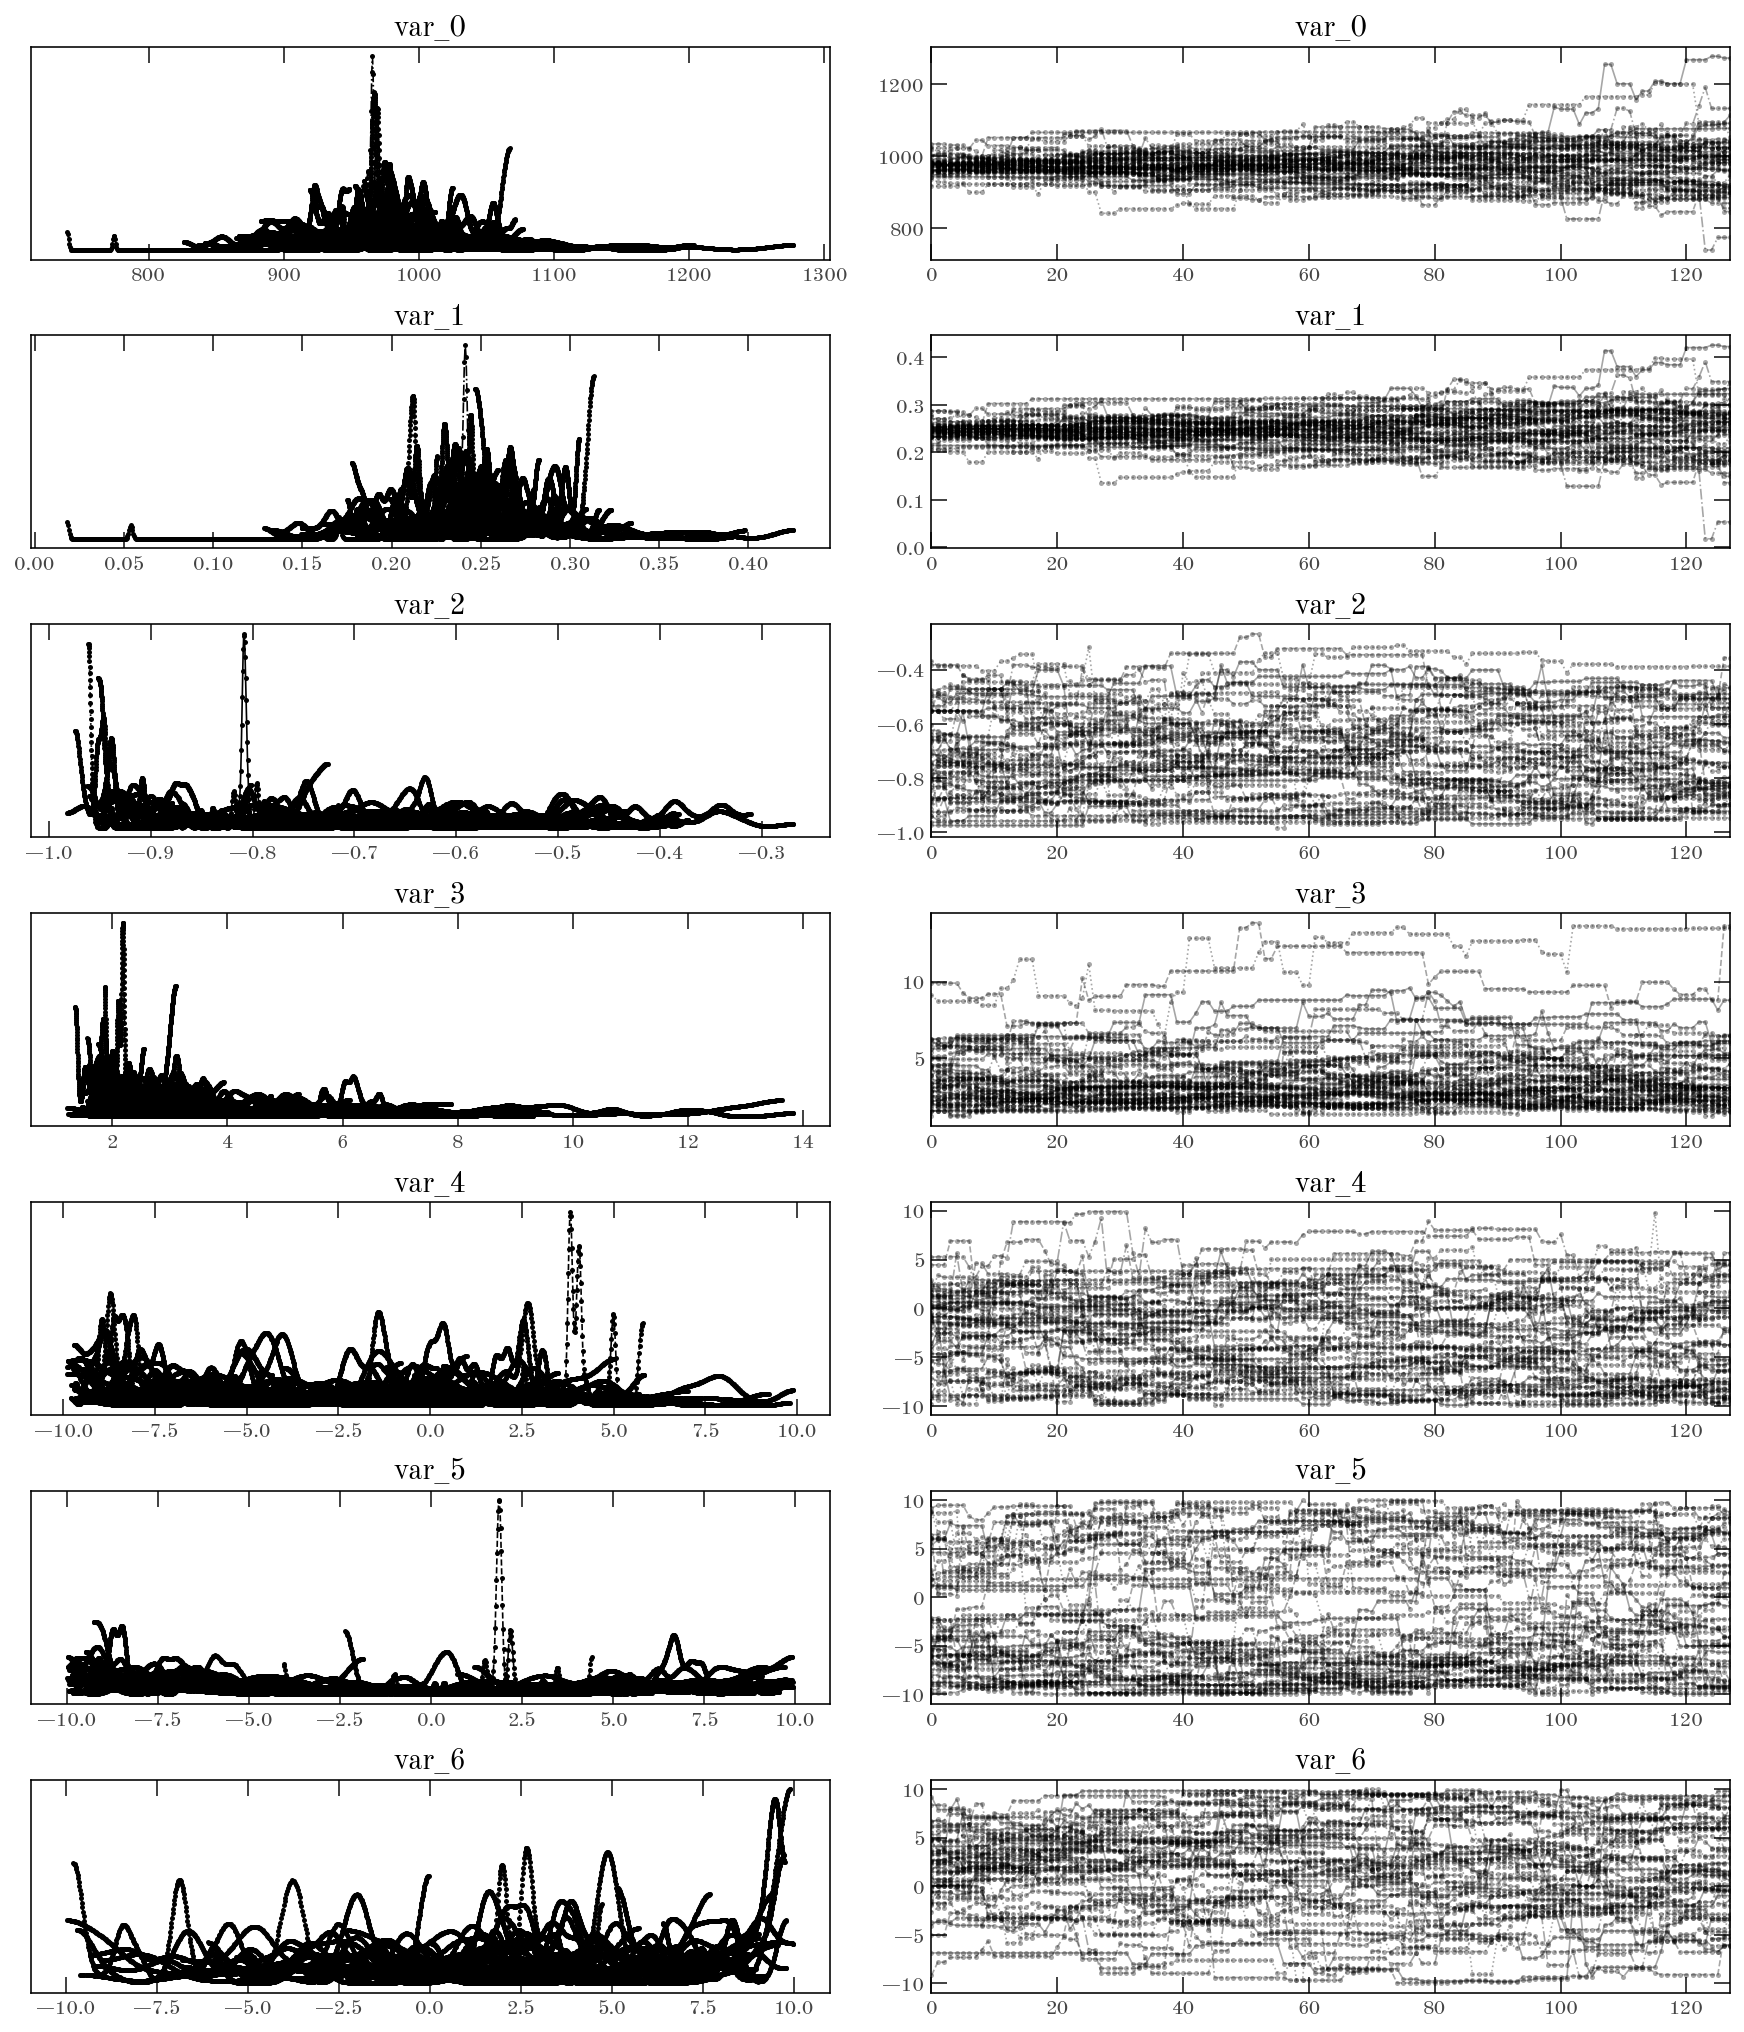

In [21]:
az.plot_trace(az.from_emcee(sampler))

In [22]:
list(model._param_info.keys())

['a', 'e_coseta', 'e_sineta', 'M', 'lg_pole_x', 'lg_pole_y', 'lg_pole_z']

array([[<AxesSubplot:ylabel='var_1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_3'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_4'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_5'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='var_0', ylabel='var_6'>,
        <AxesSubplot:xlabel='var_1'>, <AxesSubplot:xlabel='var_2'>,
        <AxesSubplot:xlabel='var_3'>, <AxesSubplot:xlabel='var_4'>,
        <AxesSubplot:xlabel='var_5'>]], dtype=object)

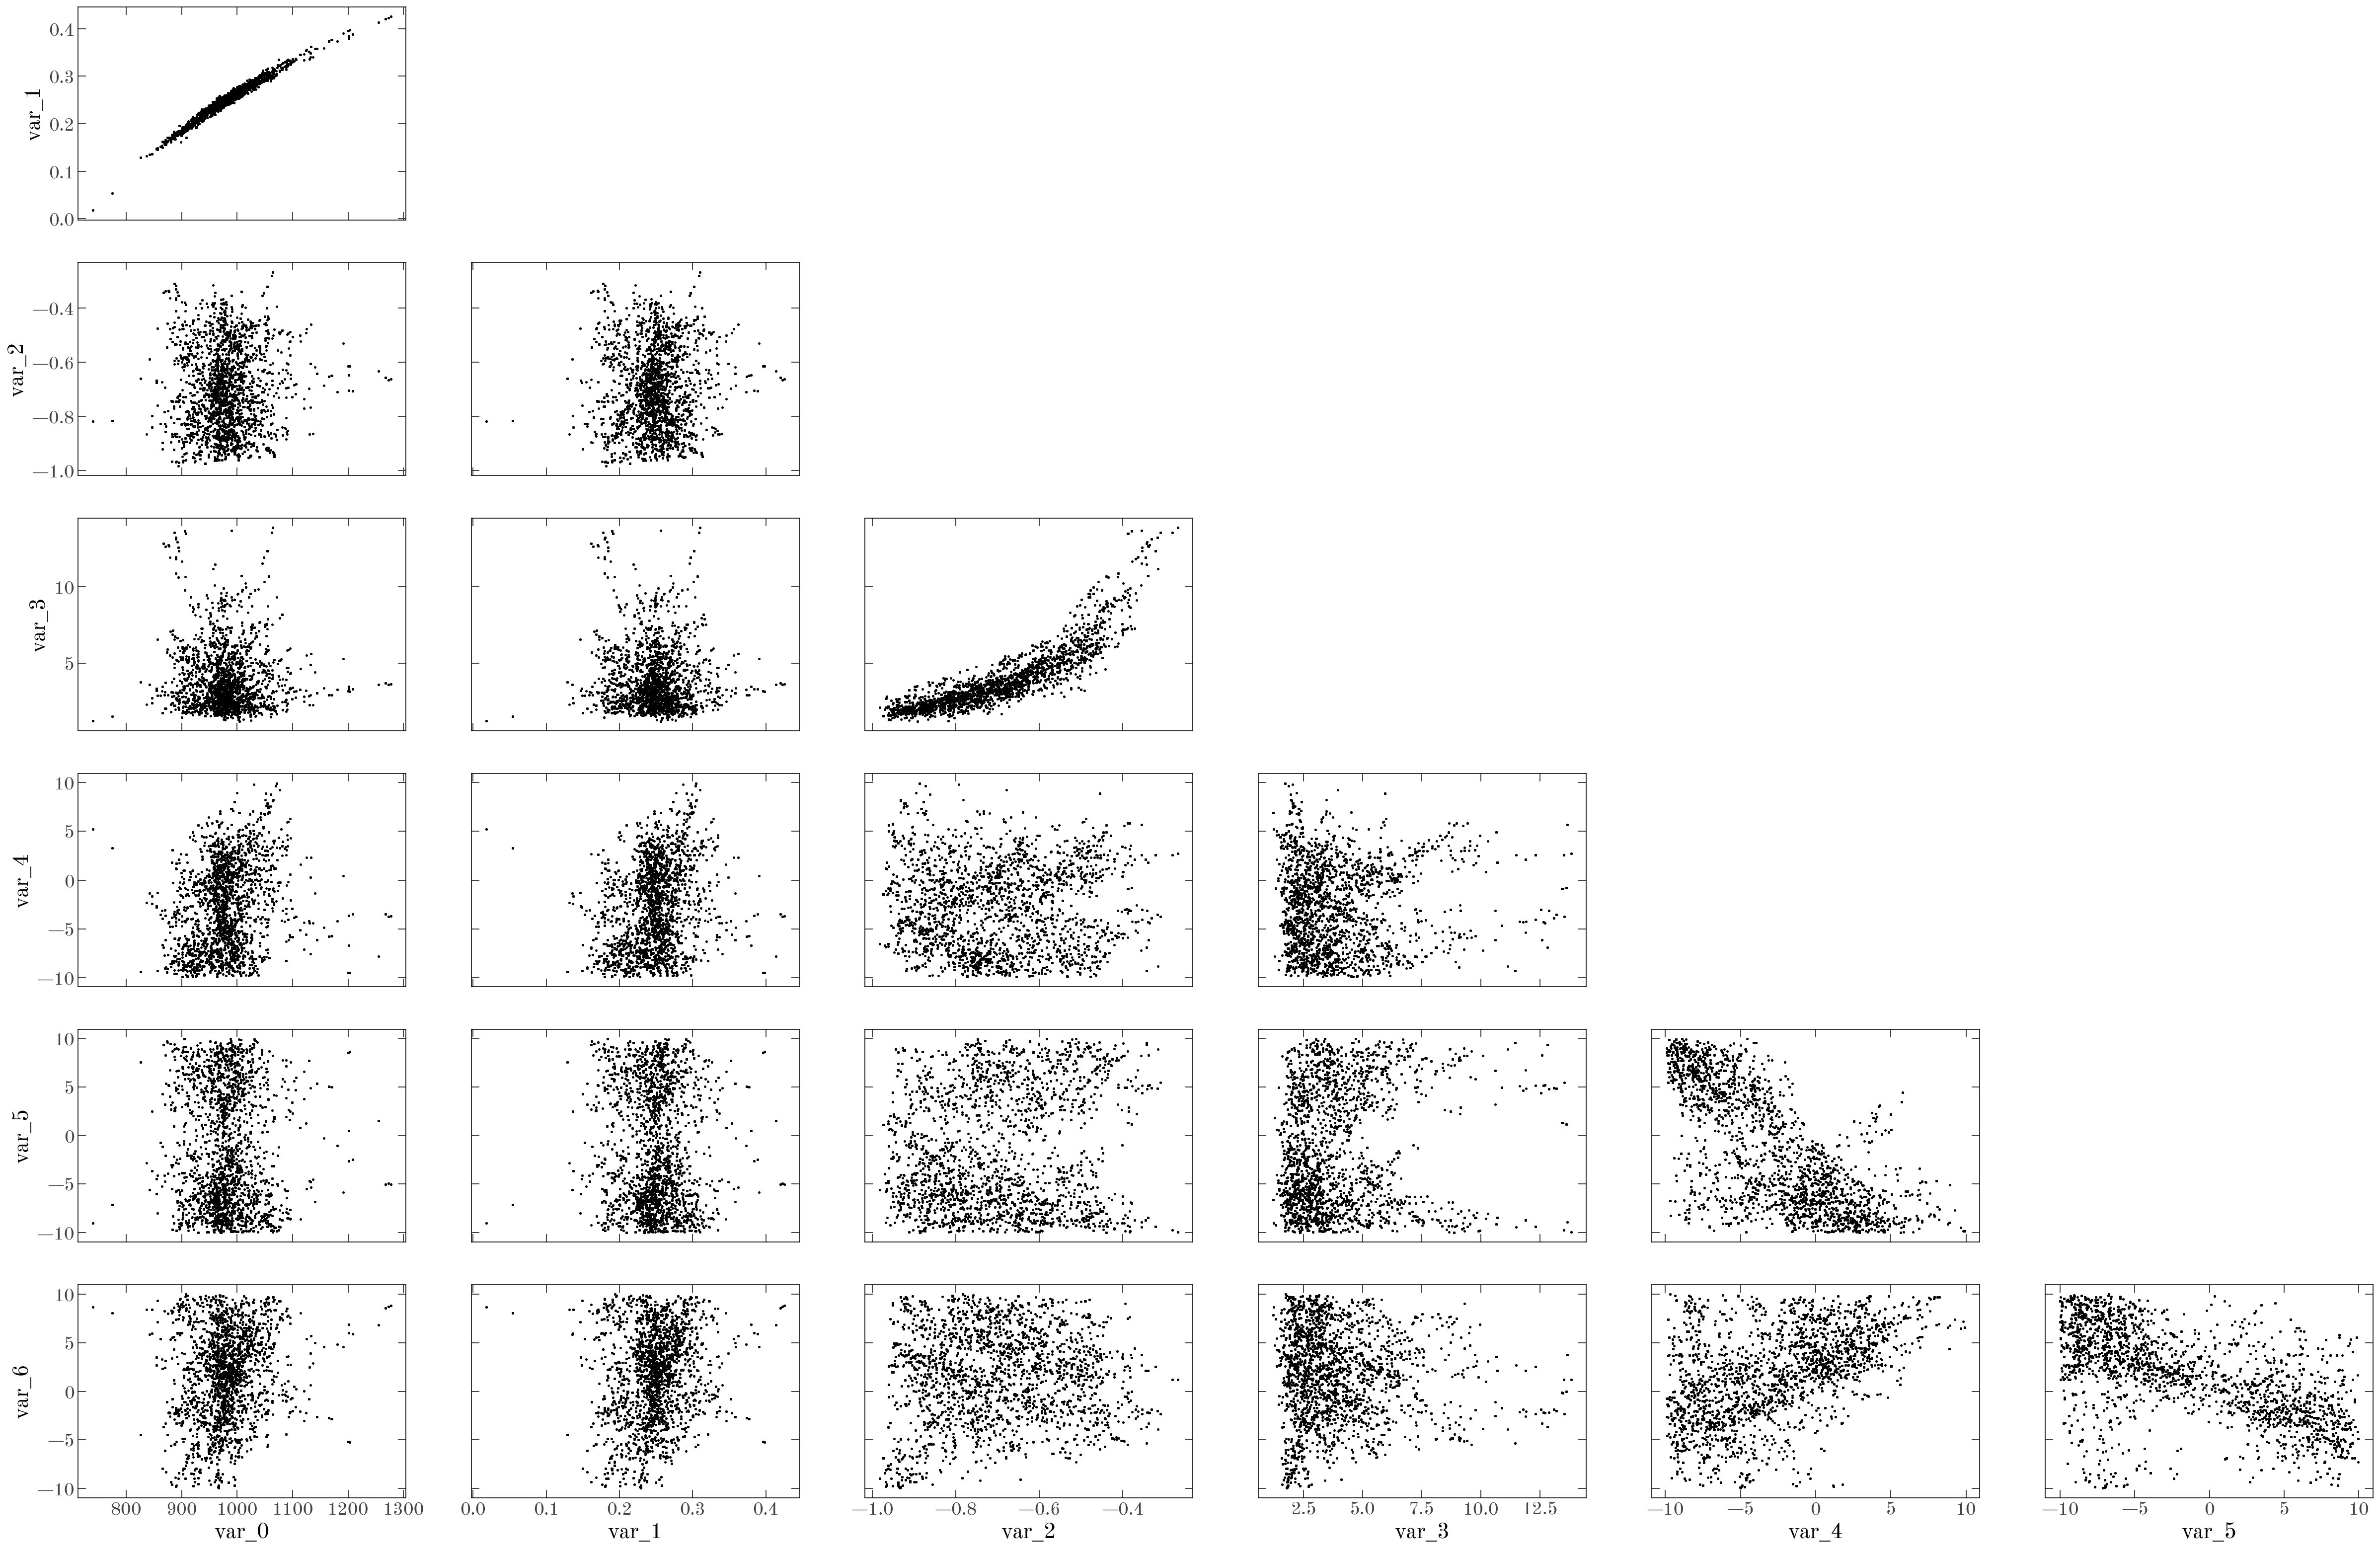

In [23]:
az.plot_pair(az.from_emcee(sampler))

In [166]:
%load_ext line_profiler

In [171]:
%lprun -f model.ln_likelihood model(model.pack_pars(init_p))

In [148]:
def ln_normal(x, mu, sigma):
    var = sigma ** 2
    return -0.5 * (np.log(2*np.pi * var) + (x-mu)**2 / var)


class TimingModel:
    
    def __init__(self, galcen_frame, usys):
        self.usys = usys
        self.G = G.decompose(usys).value
        self.galcen_frame = galcen_frame
    
    def params_to_model_observables(self, a, e, eta, M_LG, f_M):
        r = a * (1 - e * np.cos(eta))
        t_peri = (a**3 / (self.G * M_LG)) ** (1/2) * (eta - e * np.sin(eta))
        
        P = np.sqrt(4*np.pi**2 * a**3 / (self.G * M_LG))
        n = 2 * np.pi / P
        f = 2 * np.arctan(np.sqrt((1+e) / (1-e)) * np.tan(eta / 2))
        
        x = r * np.cos(f)
        y = r * np.sin(f)
        
        xdot = n * a / np.sqrt(1 - e**2) * -np.sin(f)
        ydot = n * a / np.sqrt(1 - e**2) * (e + np.cos(f))
        
        x_M31 = 1 / (1 + f_M) * x * self.usys['length']
        y_M31 = 1 / (1 + f_M) * y * self.usys['length']
        
        xdot_M31 = 1 / (1 + f_M) * xdot * self.usys['velocity']
        ydot_M31 = 1 / (1 + f_M) * ydot * self.usys['velocity']
        
        m31_pos = coord.CartesianRepresentation(x_M31, y_M31, 0*u.kpc)
        m31_vel = coord.CartesianDifferential(xdot_M31, ydot_M31, 0*u.km/u.s)
        
        m31_galcen = LGBarycentric(
            m31_pos.with_differentials(m31_vel),
            M_MW_over_M_M31=f_M,
            M_LG=M_LG * self.usys['mass']
        ).transform_to(self.galcen_frame)
        
        return m31_galcen.transform_to(coord.ICRS())
    
#     def model_observables_to_params(self, m31_c): # , t_H):
        
#         m31_galcen = m31_c.transform_to(self.galcen_frame)
        
#         # I checked this: I think this angle is the same as the true anomaly
#         f = np.arctan2(m31_galcen.y, m31_galcen.x)
#         r = m31_galcen.spherical.distance.decompose(self.usys).value
        
#         vx = m31_galcen.v_x.decompose(self.usys).value
#         vy = m31_galcen.v_y.decompose(self.usys).value
        
#         def func(p):
#             a_over_r, e, M_LG = p
            
#             a = a_over_r * r
#             eta = 2 * np.arctan(np.tan(f / 2) * np.sqrt((1-e)/(1+e)))
#             P = np.sqrt(4*np.pi**2 * a**3 / (self.G * M_LG))
#             n = 2 * np.pi / P
            
#             return np.sum(
#                 np.array([
#                     (1 - a / r * (1 - e**2) / (1 + e*np.cos(f))),
#                     vx - -n*a / np.sqrt(1 - e**2) * np.sin(f),
#                     vy - n*a / np.sqrt(1 - e**2) * (e + np.cos(f))
#                 ]) ** 2
#             )
        
#         return minimize(func, x0=[1., 0.5, 3.], bounds=[(0, 10), (0, 1), (0.5, 5)])
    
    def ln_likelihood(self, p):
        a, e_cosf, e_sinf, ln_M_LG, ln_f_M = p
        
        e = e_cosf**2 + e_sinf**2
        f = np.arctan2(e_sinf, e_cosf)
        if not 0 <= e < 1:
            return - np.inf
        
        eta = 2 * np.arctan(np.tan(f / 2) * np.sqrt((1-e) / (1+e)))
        
        M_LG = np.exp(ln_M_LG)
        f_M = np.exp(ln_f_M)
        
        model_M31_c = self.params_to_model_observables(a, e, eta, M_LG, f_M)

        ll = (
            ln_normal(model_M31_c.ra.degree, m31_c.ra.degree, 1e-3) +
            ln_normal(model_M31_c.dec.degree, m31_c.dec.degree, 1e-3) +
            ln_normal(model_M31_c.distance.to_value(u.kpc), m31_c.distance.to_value(u.kpc), 5.) +
            ln_normal(model_M31_c.pm_ra_cosdec.to_value(u.microarcsecond/u.year), 
                      m31_c.pm_ra_cosdec.to_value(u.microarcsecond/u.year), 
                      10.) +
            ln_normal(model_M31_c.pm_dec.to_value(u.microarcsecond/u.year), 
                      m31_c.pm_dec.to_value(u.microarcsecond/u.year), 
                      8.) +
            ln_normal(model_M31_c.radial_velocity.value,
                      m31_c.radial_velocity.value, 
                      10.)
        )
        
        return ll

In [149]:
galcen_frame = coord.Galactocentric()
model = TimingModel(galcen_frame, usys)

In [150]:
e = 0.5
eta = 300 * u.deg

m31_galcen = m31_c.transform_to(galcen_frame)
a = m31_galcen.spherical.distance / (1 - e * np.cos(eta))

M_LG = 3e12 * u.Msun
f_M = 0.75

x0 = [
    a.decompose(model.usys).value,
    0.6,
    0.4,
    np.log(M_LG.decompose(model.usys).value),
    np.log(f_M)
]
model.ln_likelihood(x0)

-1860176.5218392268

In [151]:
res = minimize(lambda *args: -model.ln_likelihood(*args), 
               x0=x0, method='powell')
res

In [152]:
res

   direc: array([[-3.71663146e+01, -1.95602846e-03,  4.16016990e-05,
         1.92355009e+00, -1.47330108e-02],
       [-1.20982975e+02, -1.31485294e-02, -6.68510530e-05,
        -2.40516963e-01, -1.34208419e-02],
       [-7.08887562e+00,  2.66026126e-04,  4.93987630e-05,
         6.73328615e-02, -2.00153251e-03],
       [-1.63375405e+00,  1.50852328e-07,  4.67380119e-05,
        -4.80396269e-02, -2.81005287e-04],
       [-3.81300916e+01, -8.05403283e-03,  1.51295534e-05,
         6.02685759e-03, -5.84474585e-04]])
     fun: 24.343300995428738
 message: 'Optimization terminated successfully.'
    nfev: 2221
     nit: 38
  status: 0
 success: True
       x: array([ 3.66317096e+03,  4.72749324e-01, -4.39552671e-05,  8.90358193e-01,
       -6.09998527e-02])

In [153]:
a, e_cosf, e_sinf, ln_M_LG, ln_f_M = res.x

e = e_cosf**2 + e_sinf**2
np.exp(ln_M_LG), np.exp(ln_f_M)

(2.436002052770694, 0.940823378352931)

In [155]:
e, a

(0.22349192490040026, 3663.170956893758)

---

In [67]:
from twobody import TwoBodyKeplerElements, KeplerOrbit
from twobody.anomaly import *
from astropy.time import Time

In [60]:
elem = TwoBodyKeplerElements(P=1000*u.day, e=0.4, m1=1*u.Msun, m2=0.7*u.Msun, omega=0*u.rad, 
                             t0=Time(55555., format='mjd'), M0=0*u.deg, i=90*u.deg)
elem

<TwoBodyKeplerElements [m1=1.00 solMass, m2=0.70 solMass, P=1000.00 d, a=2.34 AU, e=0.40, ω=0.00 deg, i=90.00 deg, Ω=0.00 deg]>

In [61]:
o1 = KeplerOrbit(elem.primary)
o2 = KeplerOrbit(elem.secondary)

In [65]:
tt = Time(55555. + 831., format='mjd')
xv1 = o1.orbital_plane(tt)
xv2 = o2.orbital_plane(tt)

In [75]:
dx = xv2.without_differentials() - xv1.without_differentials()
dx.represent_as(coord.SphericalRepresentation)

<SphericalRepresentation (lon, lat, distance) in (rad, rad, AU)
    (4.40533175, 0., 0.39385072)>

In [76]:
M = 2*np.pi*u.rad * (tt - elem.t0) / elem.P
E = eccentric_anomaly_from_mean_anomaly(M, e=elem.e)
f = true_anomaly_from_eccentric_anomaly(E, elem.e)
f

<Quantity 4.40533167 rad>